Responsible AI - Project on algorithmic fairness

In [931]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [932]:
# read data from csv file
df = pd.read_csv('data/catalan-juvenile-recidivism-subset.csv')

In [933]:
df.head()

,id,V1_sex,V4_area_origin,V6_province,V8_age,V9_age_at_program_end,V11_criminal_record,V12_n_criminal_record,V13_n_crime_cat,V15_main_crime_cat,...,V28_days_from_crime_to_program,V29_program_duration,V115_RECID2015_recid,V10_date_of_birth_year,V10_date_of_birth_month,V22_main_crime_date_year,V22_main_crime_date_month,V30_program_start_year,V30_program_start_month,V31_program_end_month
0,691,male,Spain,Lleida,15,17,1,1-2,3+,Against People,...,587.0,132,1,1992,11,2008,8,2010,4,8
1,956,female,Spain,Barcelona,14,15,1,1-2,2,Against People,...,107.0,258,1,1995,7,2009,8,2009,12,8
2,2560,male,Maghreb,Barcelona,15,16,1,3-5,3+,Against People,...,135.0,85,1,1994,1,2009,11,2010,3,6
3,2018,male,Maghreb,Girona,14,15,1,5+,2,Against People,...,176.0,271,1,1994,4,2009,1,2009,6,3
4,1650,male,Spain,Tarragona,17,20,1,5+,3+,Against People,...,261.0,533,1,1990,9,2008,9,2009,5,11


In [934]:
# create profile report
import pandas as pd
from pandas_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file(output_file='output.html')


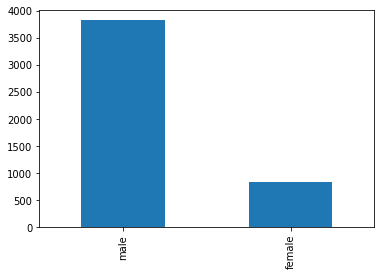

In [935]:
# some highlits from the report

# plot sex distribution
_=df.V1_sex.value_counts().plot(kind='bar')

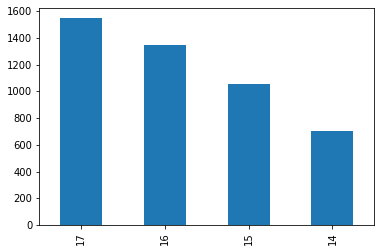

In [936]:
# plot area of origin distribution
_=df.V8_age.value_counts().plot(kind='bar')

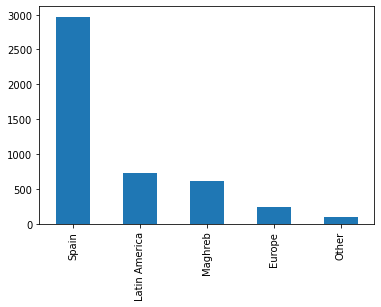

In [937]:
_=df.V4_area_origin.value_counts().plot(kind='bar')

## Training

Split the dataset into training, validation and test sets, and train a machine
learning algorithm of your choice to predict the variable Recidivism

In [938]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [939]:
def plot_roc_curves(y_test, pred_proba, legend=""):
    fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr, label=legend)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend()

In [940]:
# apply one hot encoding to categorical features
df = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == "object"])

In [941]:
X = df.drop(columns=["V115_RECID2015_recid", "id"])
y = df.V115_RECID2015_recid # Target variable

In [942]:
# Split dataset into training set and test set  # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### bootstrapping

In [943]:
# X_train["y"] = y_train
# filter_is_female = X_train.V1_sex_female == 1
# gender_diff = X_train.shape[0] - filter_is_female.sum()
# X_train = pd.concat((X_train[filter_is_female].sample(gender_diff, replace=True),X_train))
# y_train = X_train.y
# X_train = X_train.drop(columns = "y")
# # its half and half
# (X_train.V1_sex_female == 1).sum(), X_train.shape

In [944]:
X_train.V1_sex_female.sum(), X_train.V1_sex_male.sum()

(566, 2690)

In [945]:
# import sklearn random forest
from sklearn.ensemble import RandomForestClassifier

# Create Decision Tree classifer object
rfc = RandomForestClassifier()

# Train Decision Tree Classifer
rfc = rfc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rfc.predict(X_test)


In [946]:
# get probabilities from rfc
filter_is_female_test = X_test.V1_sex_female == 1
filter_is_from_Maghreb = X_test.V4_area_origin_Maghreb == 1
filter_is_from_Europe = X_test.V4_area_origin_Europe == 1

y_pred_proba_Maghreb = pd.DataFrame(rfc.predict_proba(X_test[filter_is_from_Maghreb]))[1]
y_pred_proba_Europe = pd.DataFrame(rfc.predict_proba(X_test[filter_is_from_Europe]))[1]

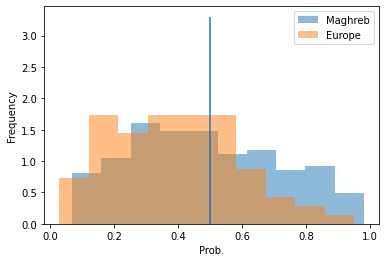

In [947]:
y_pred_proba_Maghreb.plot(kind="hist", alpha=0.5, label="Maghreb", density=1)
y_pred_proba_Europe.plot(kind="hist", alpha=0.5, label="Europe", density=1)
plt.xlabel("Prob.")
plt.vlines(0.5,0,3.3)
plt.legend()

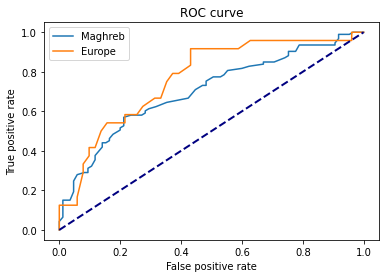

In [948]:
plot_roc_curves(y_test[filter_is_from_Maghreb], y_pred_proba_Maghreb, legend="Maghreb")
plot_roc_curves(y_test[filter_is_from_Europe], y_pred_proba_Europe, legend="Europe")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [ ]:
# calculate tpr and fpr for different thresholds
def tpr(y_pred_proba, y_test, th):
    fp = ((y_pred_proba > th) != y_test).sum()
    n = (y_test==0).sum()

def fpr(y_pred_proba, y_test, th):
    tp = ((y_pred_proba > th) == y_test).sum()
    p = y_test.sum()
    return tp/p


In [949]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7213467048710601


Please design your own criteria for diagnosing the three main definitions
of fairness: Independence, Separation and Sufficiency. Use your criteria to
perform a diagnostic test of your algorithm with respect to sensitive groups
such as race and/or gender. Please describe your designed diagnostic
criteria, as well as the results of your test. The rest of the project will be
most interesting if you have picked a classifier where you observe unfairness
at this point.

In [950]:
# ### Attributes to test
# Sex: \
# 'V1_sex_female' \
# 'V1_sex_male' 

# Origin: \
# 'V4_area_origin_Europe' \
# V4_area_origin_Latin America'\
# 'V4_area_origin_Maghreb'\
# 'V4_area_origin_Other'

# Age:\
# 'V8_age_14' \
# 'V8_age_15' \
# 'V8_age_16' \
# 'V8_age_17' 



## Independence

In [951]:
# test independence of the model
def test_independence(model,X, a, b, allowed_err=0):
    # y is the target variable
    # X is the feature matrix
    # a is the column for the first group
    # b is the column for the second group
    # for both grouqps a and b, the values are 0 or 1 (one-hot encoding)

    # create two groups
    X_a = X[X[a]==1]
    X_b = X[X[b]==1]

    # check prediction for group a and b
    y_pred_a = model.predict(X_a)
    y_pred_b = model.predict(X_b)

    # calculate p(y_pred=1|A=a) and p(y_pred=1|A=b)
    p_a = np.mean(y_pred_a)
    p_b = np.mean(y_pred_b)

    #print results
    print(f"p(y_pred=1|A={a}) = {p_a:.3f}")
    print(f"p(y_pred=1|A={b}) = {p_b:.3f}")

    if abs(p_a - p_b) <= allowed_err:
        print("The model fulfills independence")
    else:
        print("The model does not fulfill independence")

    return p_a, p_b


In [952]:
test_independence(rfc,X, "V1_sex_male", "V1_sex_female", allowed_err=0.05)

p(y_pred=1|A=V1_sex_male) = 0.340
p(y_pred=1|A=V1_sex_female) = 0.154
The model does not fulfill independence


(0.34039769754055466, 0.15421686746987953)

comment: the model discriminates males

In [953]:
# test seperation of the model
def test_seperation(model,X, y, a, b, allowed_err=0):
    # y is the target variable
    # X is the feature matrix
    # a is the column for the first group
    # b is the column for the second group
    # for both grouqps a and b, the values are 0 or 1 (one-hot encoding)

    # create four groups
    X_1_a = X[(X[a]==1) & (y==1)]
    X_1_b = X[(X[b]==1) & (y==1)]
    X_0_a = X[(X[a]==1) & (y==0)]
    X_0_b = X[(X[b]==1) & (y==0)]

    # check prediction all groups
    y_pred_1_a = model.predict(X_1_a)
    y_pred_1_b = model.predict(X_1_b)
    y_pred_0_a = model.predict(X_0_a)
    y_pred_0_b = model.predict(X_0_b)

    # calculate p(y_pred=1|Y=1, A=a) and p(y_pred=1|Y=1, A=b) etc
    p_1_a = np.mean(y_pred_1_a)
    p_1_b = np.mean(y_pred_1_b)
    p_0_a = np.mean(y_pred_0_a)
    p_0_b = np.mean(y_pred_0_b)

    #print results
    print(f"p(y_pred=1|Y=1, A={a}) = {p_1_a:.3f}")
    print(f"p(y_pred=1|Y=1, A={b}) = {p_1_b:.3f}")
    print(f"p(y_pred=1|Y=0, A={a}) = {p_0_a:.3f}")
    print(f"p(y_pred=1|Y=0, A={b}) = {p_0_b:.3f}")

    if abs(p_1_a - p_1_b) <= allowed_err and abs(p_0_a - p_0_b) <= allowed_err:
        print("The model fulfills seperation")
    else:
        print("The model does not fulfill seperation")

    return p_1_a, p_1_b, p_0_a, p_0_b

In [954]:
test_seperation(rfc,X,y, "V1_sex_male", "V1_sex_female", allowed_err=0.05)

p(y_pred=1|Y=1, A=V1_sex_male) = 0.841
p(y_pred=1|Y=1, A=V1_sex_female) = 0.700
p(y_pred=1|Y=0, A=V1_sex_male) = 0.043
p(y_pred=1|Y=0, A=V1_sex_female) = 0.014
The model does not fulfill seperation


(0.8405898876404494, 0.7, 0.043369474562135114, 0.013636363636363636)

In [955]:
_=test_seperation(rfc,X,y, 'V4_area_origin_Europe', 'V4_area_origin_Latin America')
_=test_seperation(rfc,X,y, 'V4_area_origin_Maghreb', 'V4_area_origin_Other')

p(y_pred=1|Y=1, A=V4_area_origin_Europe) = 0.867
p(y_pred=1|Y=1, A=V4_area_origin_Latin America) = 0.849
p(y_pred=1|Y=0, A=V4_area_origin_Europe) = 0.050
p(y_pred=1|Y=0, A=V4_area_origin_Latin America) = 0.042
The model does not fulfill seperation
p(y_pred=1|Y=1, A=V4_area_origin_Maghreb) = 0.879
p(y_pred=1|Y=1, A=V4_area_origin_Other) = 0.917
p(y_pred=1|Y=0, A=V4_area_origin_Maghreb) = 0.081
p(y_pred=1|Y=0, A=V4_area_origin_Other) = 0.013
The model does not fulfill seperation


In [956]:
pred_proba = pd.DataFrame(rfc.predict_proba(X_test))[1]

In [957]:
for th in np.linspace(0,1,100):
    pred = pred_proba > th
    

In [958]:
(pd.DataFrame(rfc.predict_proba(X_test))[1] > 0.5).sum()

315

In [959]:
y_test.replace(1,True).replace(0,False)

2911    False
3376    False
3631    False
1055     True
514      True
        ...  
1697    False
902      True
1308    False
1534     True
3718    False
Name: V115_RECID2015_recid, Length: 1396, dtype: bool